### GAN(Generative Adversarial Networks)

생성적 적대 신경망은 아이디어 자체로만으로도 매우 가치있는 모델로 평가 받고 있다. 실제 얼굴 변환, 음성 변조, 그림 스타일 변환, 사진 복원 등 다양한 기술로 응용이 되어 실제 적용되고 있다.

GAN은 Generator(가짜 생성)와 Discriminator(진짜/가짜 구별)가 서로 경쟁하며 학습하는 구조이다. Generator는 Discriminator를 속이려 하고, Discriminator는 이를 구별하려고 하면서 둘 다 점점 강해진다. 결국 Generator는 진짜처럼 보이는 데이터를 만들 수 있게 된다.

#### 1.라이브러리 및 데이터 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
from tqdm import trange

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# FashionMNIST : 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

# 전처리 작업을 묶어서 적용할 수 있게 한다.
transform = transforms.Compose([
                transforms.ToTensor(),  # 픽셀값 범위 [0, 255] -> [0.0, 1.0] 사이로 정규화(normalize) 해준다.
                transforms.Normalize((0.5,),(0.5,)) # [0,1]로 변환된 데이터를 [-1,1] 범위로 바꿔준다.
                ])

to_image = transforms.ToPILImage() # Tensor data -> PIL 이미지
trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f'{device} is available')


100%|██████████| 26.4M/26.4M [00:13<00:00, 2.02MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 88.4kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.09MB/s]

mps is available


#### 2. 모델 정의

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.n_features = 128 # 입력 노이즈 차원
        self.n_out = 784 # 출력은 28x28 이미지를 1차원으로 펼친 784개의 숫자
        self.linear = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2), # 약간 기울기를 줘서 죽지 않게 한다.
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh() # 출력값을 [-1, 1] 범위로 정규화
                    )
    
    # x를 Linear 통과 -> 최종적으로 (배치 크기,1채널, 28, 28) 이미지 형태로 Reshape
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.n_in = 784 # 입력은 펼쳐진 28x28 이미지 (784차원)
        self.n_out = 1 # 출력은 진짜/가짜 판별을 위한 1개의 값
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3), # 오버 피팅 방지
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )

    # 입력 이미지를 784로 펼치고 -> linear 통과 -> 진짜/가짜 확률 출력
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)

        return x

#### 3. 손실함수 및 최적화 방법 정의

In [4]:
# generator 와 discriminator 인스턴스를 생성하고 mps로 보낸다.
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False

if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner.pth'))

# 최적화기 설정
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

# 학습용 기록용 리스트 초기화
g_losses = []
d_losses = []
images = []

# 손실 함수 설정
# Binary Cross Entropy Loss 설정 (진짜/가짜를 이진 분류하는 문제에 적합)
criterion = nn.BCELoss()

# 랜덤 노이즈 생성 함수 (Generator 입력용)
def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

# 배치 크기만큼 각각 진짜(1)인지 가짜(0)인지 판단해야 한다.
# "진짜" 데이터용 정답 라벨 1 생성 함수 -> 사이즈만큼 1로 채운 (size, 1) 크기의 텐서를 생성
def label_ones(size):
    data = Variable(torch.ones(size, 1))

    return data.to(device)

# "가짜" 데이터용 정답 라벨 0 생성 함수 -> 사이즈만큼 0로 채운 (size, 1) 크기의 텐서를 생성
def label_zeros(size):
    data = Variable(torch.zeros(size, 1))

    return data.to(device)

#### 4. 학습 전략 정의

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))

    loss = d_loss + g_loss # loss가 0에 가까워야 진짜 데이터와 가자 데이터 둘다를 잘 맞추는 것이므로 0에 가까울 수록 좋다.

    loss.backward()
    optimizer.step()
    
    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

#### 학습하기

In [ ]:
num_epochs = 101
pbar = trange(num_epochs)
test_noise = noise(64) # 64개의 랜덤한 숫자 묶음, Generator가 얼마나 좋아졌는지 비교할 대상

l = len(trainloader) # 몇 번의 배치가 필요한지 저장

for epoch in pbar:
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        
        fake_data = generator(noise(n)).detach() # detach()를 안하면 train_discriminator에서 역전파할때 generator도 훈력시켜 버린다.
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    pbar.set_postfix({'epoch': epoch+1, 'g_loss' : g_loss/l, 'd_loss' : d_loss/l}) 


torch.save(discriminator.state_dict(), './models/fmnist_disc.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner.pth')   


100%|██████████| 101/101 [24:17<00:00, 14.44s/it, epoch=101, g_loss=1.09, d_loss=1.15]


#### 이미지 결과 및 손실함수 그래프 생성

In [8]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('./results/fashion_items_vnlgan.gif', imgs)

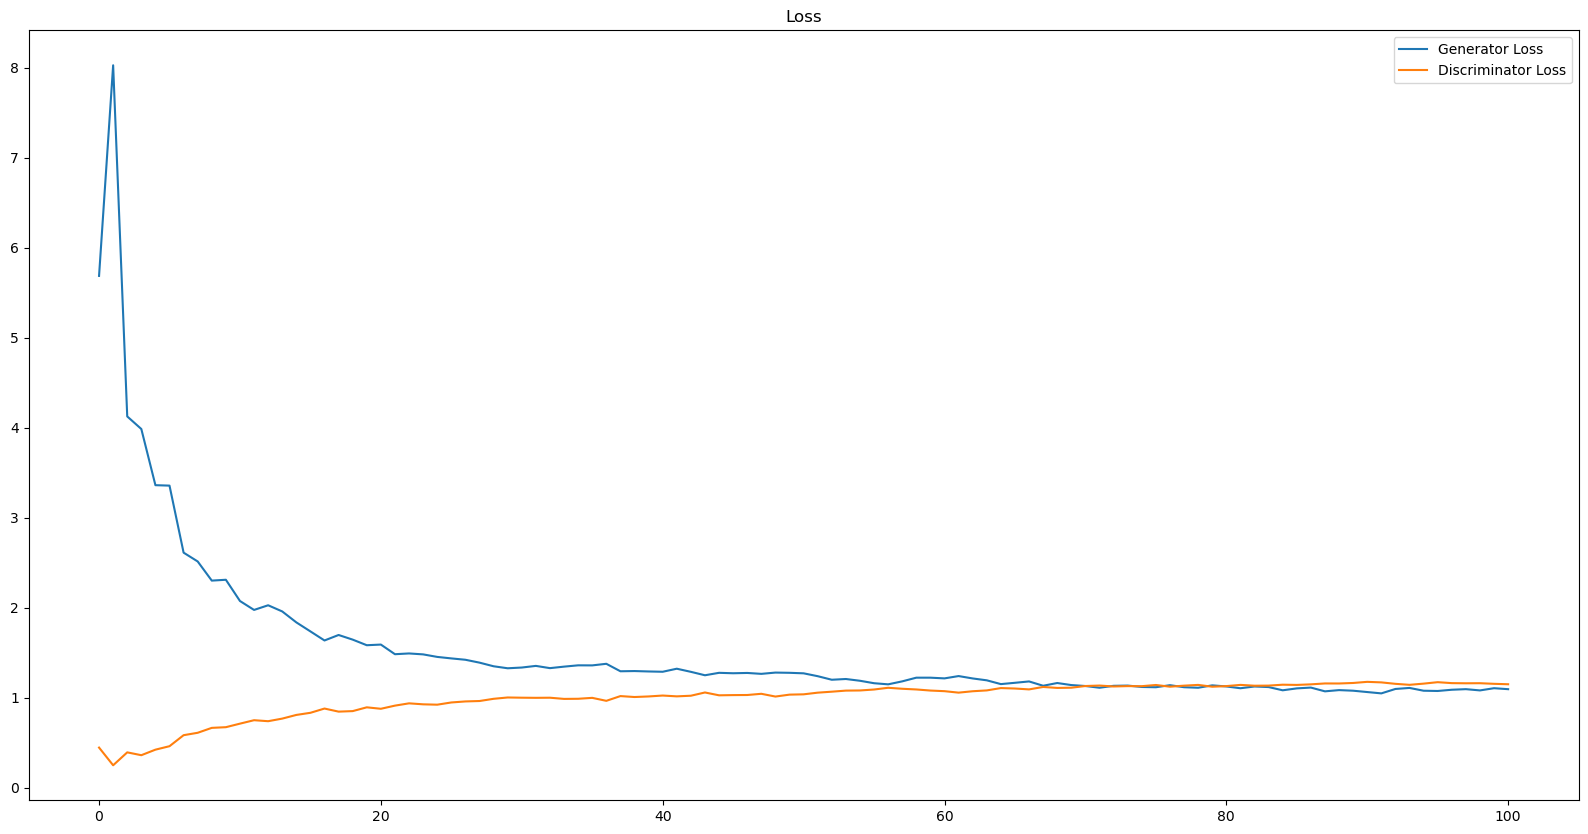

In [10]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator Loss','Discriminator Loss'])
plt.title('Loss')
plt.savefig('./results/vnlgan_loss.png')